In [130]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re


In [131]:
def get_trial_data(df, trial_name):
    # Find the start index of the trial
    start_index = df[df['USER'].str.contains(trial_name, case=False, na=False)].index[0]
    
    trial_number = trial_name.split(":")[0]
    end = f"{trial_number}: END"

    # Find the end index of the trial (next 'FIXATION_LOG' or 'STOP')
    next_fixation_mask = df['USER'].str.contains(re.escape(end), case=False, na=False)
    end_index = df[next_fixation_mask].index[df[next_fixation_mask].index > start_index].min()
    
    # If no next fixation or stop is found, take until the end of the DataFrame
    if pd.isna(end_index):
        end_index = df.shape[0]
    
    # Extract the trial data
    trial_data = df.loc[start_index:end_index]
    
    return trial_data

def dispersion(x, y):
    return (np.max(x)-np.min(x)) + (np.max(y)-np.min(y))

def i_dt(x, y, disp_t, dur_t_ms=100, smpl_freq=500):

    # compute number of samples in a time window
    dur_t_s = dur_t_ms/1000 # convert duration threshold to seconds
    dur_t = int(dur_t_s*smpl_freq)

    # initialize index
    i = 0
    fixations = {"fix_start_idx":[], "fix_end_idx":[]}

    # find the start and end of a fixation using the dispersion threshold and the time window
    while i + dur_t <= len(x):
        window_x = x.iloc[i:i+dur_t]
        window_y = y.iloc[i:i+dur_t]
        disp = dispersion(window_x,window_y)

        if disp > disp_t:
            i += 1
            continue

        j = 1
        while (i + dur_t + j <= len(x)) and (dispersion(x.iloc[i:i+dur_t+j],y.iloc[i:i+dur_t+j]) <= disp_t):
            j += 1

        j -= 1

        fixations["fix_start_idx"].append(i)
        fixations["fix_end_idx"].append(i+dur_t+j-1)

        i = i + dur_t + j

    return fixations

In [132]:
def label_fixation(row):
    if 0.4 <= row['BPOGX_start'] <= 0.6:
        return 'no image'
    elif 0.6 < row['BPOGX_start'] :
        return 'right image'
    elif row['BPOGX_start'] < 0.4:
        return 'left image'
    else:
        return 'unknown'


In [180]:
def firstFixationPoints(subject_number,df_subject,condition_trials):
    fixation_points = []
    count = 0
    for index, row in condition_trials.iterrows():   
        trial_name = row['USER']
        trial_data = get_trial_data(df_subject, trial_name)
        count = count + 1
        results_trial = i_dt(trial_data["BPOGX"], trial_data["BPOGY"], disp_t=0.15)
        results_trial_df = pd.DataFrame(results_trial)
        results_trial_df['subject'] = subject_number
        if results_trial_df.empty:
            continue 

        results_trial_df["fix_start"] = trial_data["TIME"].iloc[results_trial_df["fix_start_idx"]].values
        results_trial_df["fix_end"] = trial_data["TIME"].iloc[results_trial_df["fix_end_idx"]].values
        results_trial_df["fix_dur"] = results_trial_df["fix_end"] - results_trial_df["fix_start"]

        results_trial_df["BPOGX_start"] = trial_data["BPOGX"].iloc[results_trial_df["fix_start_idx"]].values
        results_trial_df["BPOGX_end"] = trial_data["BPOGX"].iloc[results_trial_df["fix_end_idx"]].values
        results_trial_df["BPOGY_start"] = trial_data["BPOGY"].iloc[results_trial_df["fix_start_idx"]].values
        results_trial_df["BPOGY_end"] = trial_data["BPOGY"].iloc[results_trial_df["fix_end_idx"]].values
        results_trial_df["label"] = results_trial_df.apply(label_fixation, axis=1)

            # filter the trial name, so that only the text after the : exits
            #trial_name_condition = trial_name.split(':')[-1].strip() 


        match = re.search(r'TRIAL \d+: ([^,]+), LEFT IMAGE: ([^,]+), RIGHT IMAGE: ([^,]+)', trial_name)

        if match:
            trial_name_condition = match.group(1).strip()
            left_image = match.group(2).strip()
            right_image = match.group(3).strip()

        #print("Trial Name:", trial_name_condition)
        #print("Left Image:", left_image)
        #print("Right Image:", right_image)
            #trial_name_condition = trial_name.split(":")[1].split(",")[0].strip()

            # then split the trial name by _
        trial_name_parts = trial_name_condition.split('_')

        form_level = ['ASYMMETRICAL','SYMMETRICAL']
        size_level = ['BIG','SMALL']
        background_level = ['CONTRARY','DOMINANT']

        if(trial_name_parts[0] == 'SIZE'):
            trial_cond = size_level
        elif(trial_name_parts[0] == 'FORM'):
            trial_cond = form_level
        elif(trial_name_parts[0] == "BACKGROUND"):
            trial_cond = background_level

        if(trial_name_parts[0] != 'BASELINE'):
            # if trial_name_parts[1]  is BIG then add label BIG to column 'level' if it is SMALL then add label SMALL
            if trial_name_parts[1].upper() == trial_cond[0]:
                results_trial_df['level'] = trial_cond[0]
            elif trial_name_parts[1].upper() == trial_cond[1]:
                results_trial_df['level'] = trial_cond[1]
            else:
                results_trial_df['level'] = 'UNKNOWN'
            # if trial_name_parts[2]  is L add label L to column 'image' , if it is R then add R
        if trial_name_parts[2].upper() == 'L':
            results_trial_df['image'] = 'L'
        elif trial_name_parts[2].upper() == 'R':
            results_trial_df['image'] = 'R'
        else:
            results_trial_df['image'] = 'UNKNOWN'
            # if left image contains INDOOR, then assign INDOOR label to column 'ImageCategoryLeft', if left image contains NATURE, then assign NATURE label to column 'ImageCategoryLeft',
            # if left image contains URBAN, then assign URBAN label to column 'ImageCategoryLeft',same for the right image
        if 'INDOOR' in left_image.upper():
            results_trial_df['ImageCategoryLeft'] = 'INDOOR'
        elif 'NATURE' in left_image.upper():
            results_trial_df['ImageCategoryLeft'] = 'NATURE'
        elif 'URBAN' in left_image.upper():
            results_trial_df['ImageCategoryLeft'] = 'URBAN'
        else:
            results_trial_df['ImageCategoryLeft'] = 'UNKNOWN'

        if 'INDOOR' in right_image.upper():
            results_trial_df['ImageCategoryRight'] = 'INDOOR'
        elif 'NATURE' in right_image.upper():
            results_trial_df['ImageCategoryRight'] = 'NATURE'
        elif 'URBAN' in right_image.upper():
            results_trial_df['ImageCategoryRight'] = 'URBAN'
        else:
            results_trial_df['ImageCategoryRight'] = 'UNKNOWN'

        valid_fixations = results_trial_df[results_trial_df['label'] != 'no image']
        if valid_fixations.empty:
            continue  # no valid fixations

        first_valid = valid_fixations.iloc[0]
        if trial_name_parts[0] == 'BASELINE':
            fixation_points.append({
            'trial': trial_name,
            'condition': trial_name_parts[0],
            'image' : first_valid['image'],
            'left_cat': first_valid['ImageCategoryLeft'],
            'right_cat': first_valid['ImageCategoryRight'],
            'label': first_valid['label'],
            'subject' : first_valid['subject']
            })
        else:
            fixation_points.append({
                'trial': trial_name,
                'condition': trial_name_parts[0],
                'level' : first_valid['level'],
                'image' : first_valid['image'],
                'left_cat': first_valid['ImageCategoryLeft'],
                'right_cat': first_valid['ImageCategoryRight'],
                'label': first_valid['label'],
                'subject' : first_valid['subject']
            })
    return fixation_points


def plotDistribution(fixation_points):

    level_one = []
    level_two = []
    level_baseline = []

    form_level = ['ASYMMETRICAL','SYMMETRICAL']
    size_level = ['BIG','SMALL']
    background_level = ['CONTRARY','DOMINANT']

    size = False
    form = False
    background = False

    for item in fixation_points:
        if(item['condition'] == 'SIZE'):
            trial_cond = size_level
            size = True
        elif(item['condition'] == 'FORM'):
            trial_cond = form_level
            form = True
        elif(item['condition'] == "BACKGROUND"):
            trial_cond = background_level
            background = True
        if item['condition'] != 'BASELINE':
            if item['level'] == trial_cond[0]:
                level_one.append(item)
            elif item['level'] == trial_cond[1]:
                level_two.append(item)
            else:
                print('Not the right level!!')
        else:
            level_baseline.append(item)

    count_R_right_1 = 0
    count_R_left_1 = 0
    count_L_right_1 = 0
    count_L_left_1 = 0

    for item in level_one:
        if item['condition'] != 'BASELINE':
            if item['image'] == 'R':
                if item['label'] == 'right image':
                    count_R_right_1 = count_R_right_1 + 1
                elif item['label'] == 'left image':
                    count_R_left_1 = count_R_left_1 + 1
                else: 
                    print('No valid first fixation.')
            elif item['image'] == 'L':
                if item['label'] == 'right image':
                    count_L_right_1 = count_L_right_1 + 1
                elif item['label'] == 'left image':
                    count_L_left_1 = count_L_left_1 + 1
                else: 
                    print('No valid first fixation.')

    count_R_right_2 = 0
    count_R_left_2 = 0
    count_L_right_2 = 0
    count_L_left_2 = 0

    for item in level_two:
        if item['condition'] != 'BASELINE':
            if item['image'] == 'R':
                if item['label'] == 'right image':
                    count_R_right_2 = count_R_right_2 + 1
                elif item['label'] == 'left image':
                    count_R_left_2 = count_R_left_2 + 1
                else: 
                    print('No valid first fixation.')
            elif item['image'] == 'L':
                if item['label'] == 'right image':
                    count_L_right_2 = count_L_right_2 + 1
                elif item['label'] == 'left image':
                    count_L_left_2 = count_L_left_2 + 1
                else: 
                    print('No valid first fixation.')


    count_right_baseline = 0
    count_left_baseline = 0
    baseline = False
    for item in level_baseline:
        if item['condition'] == 'BASELINE':
            baseline = True
            if item['label'] == 'right image':
                count_right_baseline = count_right_baseline + 1
            elif item['label'] == 'left image':
                count_left_baseline = count_left_baseline + 1
            else: 
                print('No valid first fixation.')

    barWidth = 0.25
    if baseline == False:
        fig = plt.subplots(figsize=(12,8))
        plt.grid(True)
        plt.legend()

        RightImage = [count_L_right_1, count_R_right_1]
        LeftImage = [count_L_left_1, count_R_left_1]

        bar1 = np.arange(len(LeftImage))
        bar2 = [x + barWidth for x in bar1]

        plt.bar(bar1, LeftImage, color = 'r', width = barWidth, edgecolor = 'r', label = 'First Fixation left Image')
        plt.bar(bar2, RightImage, color = 'b', width = barWidth, edgecolor = 'b', label = 'First Fixation right Image')

        if size == True: 
            plt.title('Condition SIZE')
        if form == True:
            plt.title('Condition FORM')

        if background == True:
            plt.title('Condition BACKGROUND')

        tickLeft = trial_cond[0] + 'ConditionLeft'
        tickRight = trial_cond[0] + 'ConditionRight'

        plt.xticks([r + barWidth/2 for r in range(len(LeftImage))], [tickLeft, tickRight])
        max_y = max(max(LeftImage), max(RightImage), 2)
        plt.yticks(np.arange(0, max_y + 2, 2))


        fig = plt.subplots(figsize=(12,8))
        plt.grid(True)
        plt.legend()

        RightImage2 = [count_L_right_2, count_R_right_2]
        LeftImage2 = [count_L_left_2, count_R_left_2]

        bar1_2 = np.arange(len(LeftImage2))
        bar2_2 = [x + barWidth for x in bar1_2]

        plt.bar(bar1_2, LeftImage2, color = 'r', width = barWidth, edgecolor = 'r', label = 'First Fixation left Image')
        plt.bar(bar2_2, RightImage2, color = 'b', width = barWidth, edgecolor = 'b', label = 'First Fixation right Image')

        
        if size == True: 
            plt.title('Condition SIZE')
        if form == True:
            plt.title('Condition FORM')
        if background == True:
            plt.title('Condition BACKGROUND')

        tickLeft = trial_cond[1] + 'ConditionLeft'
        tickRight = trial_cond[1] + 'ConditionRight'

        plt.xticks([r + barWidth/2 for r in range(len(LeftImage2))], [tickLeft, tickRight])
        max_y = max(max(LeftImage2), max(RightImage2), 2)
        plt.yticks(np.arange(0, max_y + 2, 2))

    else: 
        baseline = False
        fig = plt.subplots(figsize=(12,8))
        plt.grid(True)

        counts = [count_left_baseline, count_right_baseline]
        images = ['First Fixation Left', 'First Fixation Right']

        plt.bar(images, counts, color = 'r', width = barWidth, edgecolor = 'r')
        plt.title('Condition BASELINE')
    plt.legend()
    plt.show()


C:\Users\madle\AppData\Local\Temp\ipykernel_1256\880726800.py:2: DtypeWarning: Columns (41) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_path, sep='\t')
C:\Users\madle\AppData\Local\Temp\ipykernel_1256\2966073293.py:279: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


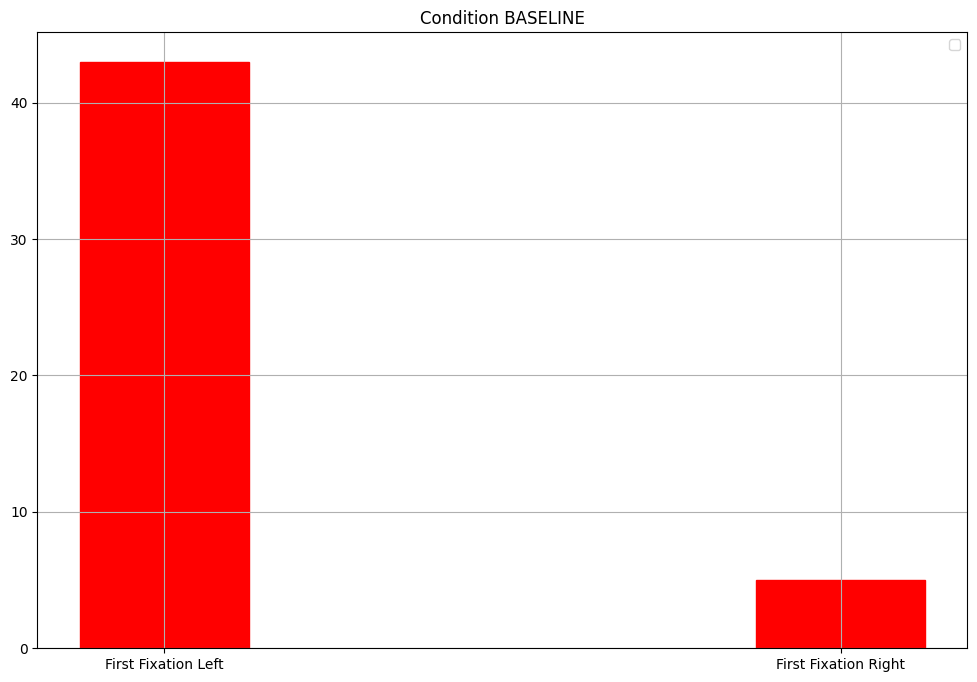

C:\Users\madle\AppData\Local\Temp\ipykernel_1256\880726800.py:2: DtypeWarning: Columns (41) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_path, sep='\t')
C:\Users\madle\AppData\Local\Temp\ipykernel_1256\2966073293.py:214: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
C:\Users\madle\AppData\Local\Temp\ipykernel_1256\2966073293.py:243: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


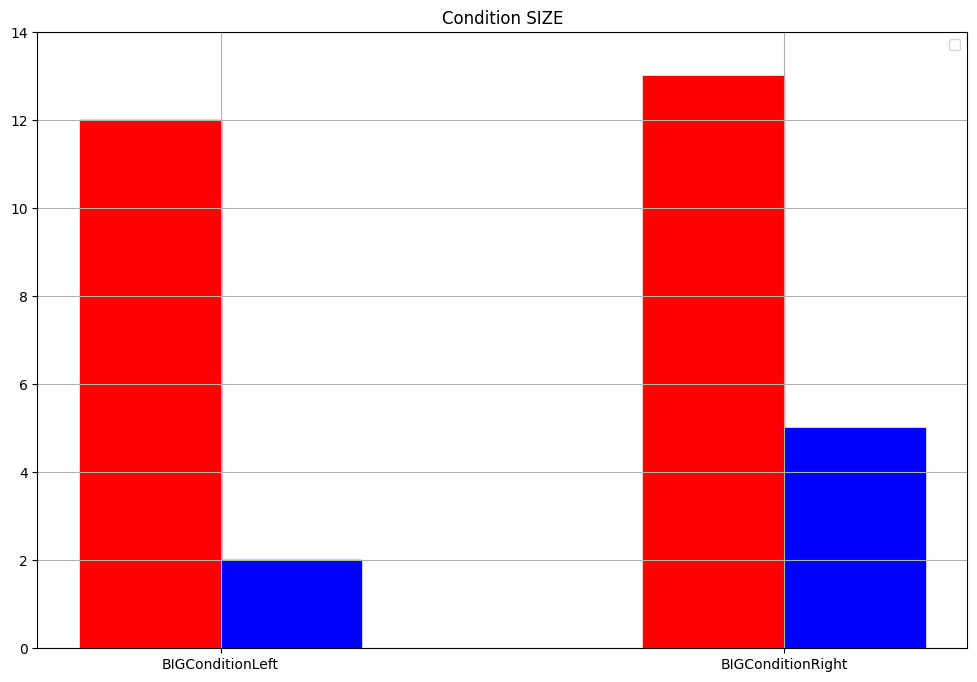

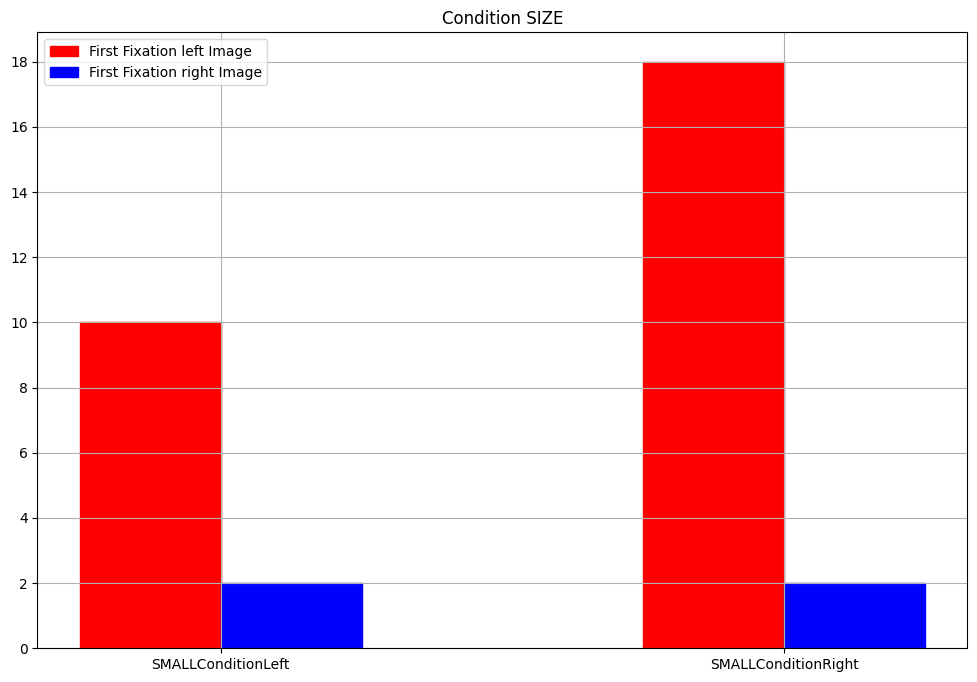

C:\Users\madle\AppData\Local\Temp\ipykernel_1256\880726800.py:2: DtypeWarning: Columns (41) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_path, sep='\t')
C:\Users\madle\AppData\Local\Temp\ipykernel_1256\2966073293.py:214: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
C:\Users\madle\AppData\Local\Temp\ipykernel_1256\2966073293.py:243: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


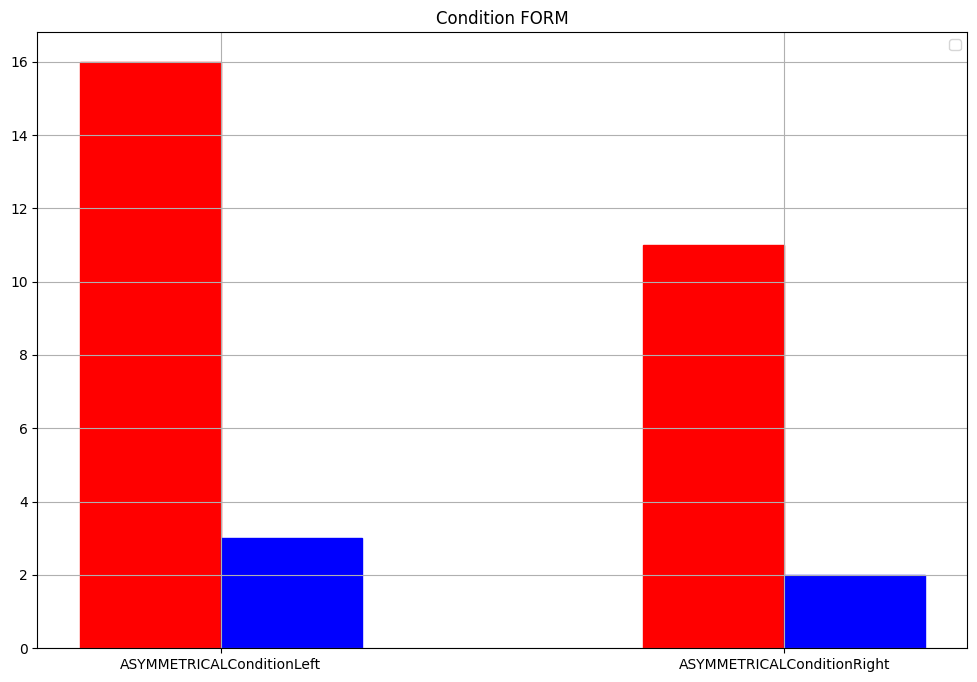

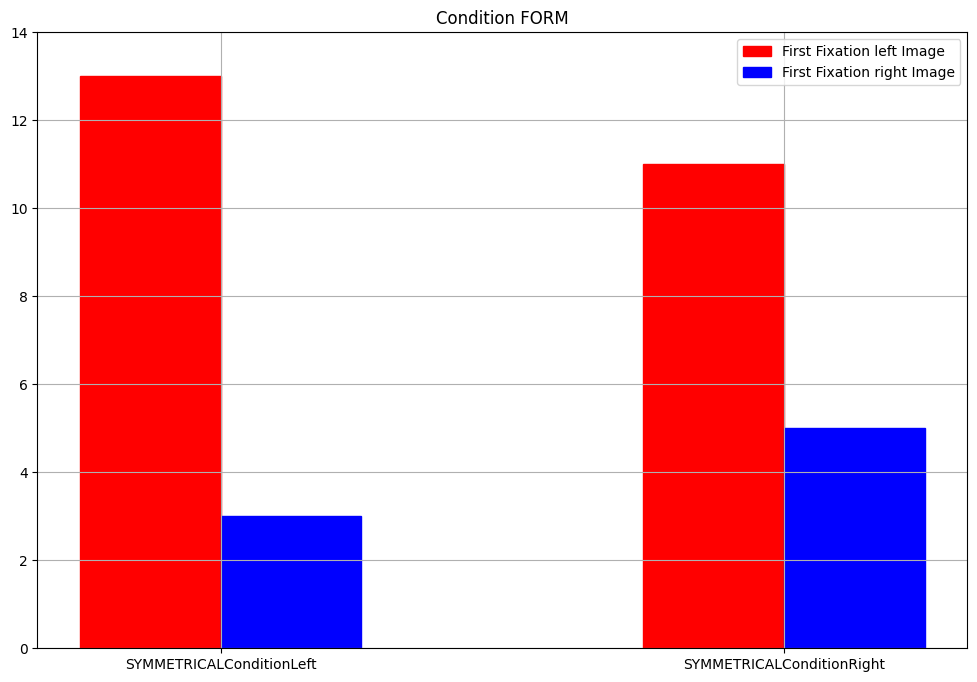

C:\Users\madle\AppData\Local\Temp\ipykernel_1256\880726800.py:2: DtypeWarning: Columns (41) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_path, sep='\t')
C:\Users\madle\AppData\Local\Temp\ipykernel_1256\2966073293.py:214: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
C:\Users\madle\AppData\Local\Temp\ipykernel_1256\2966073293.py:243: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


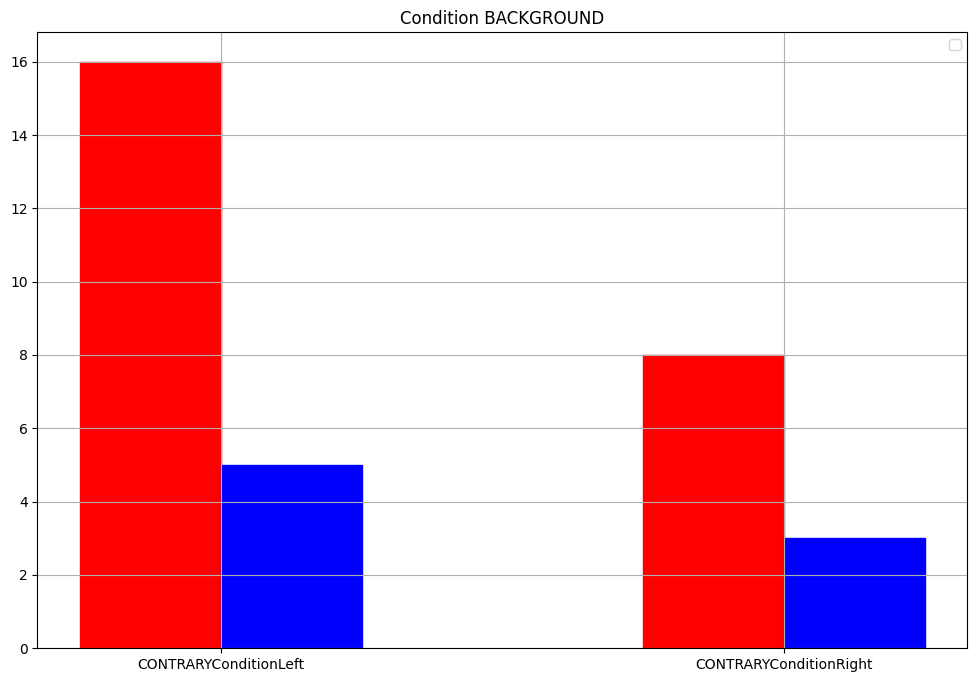

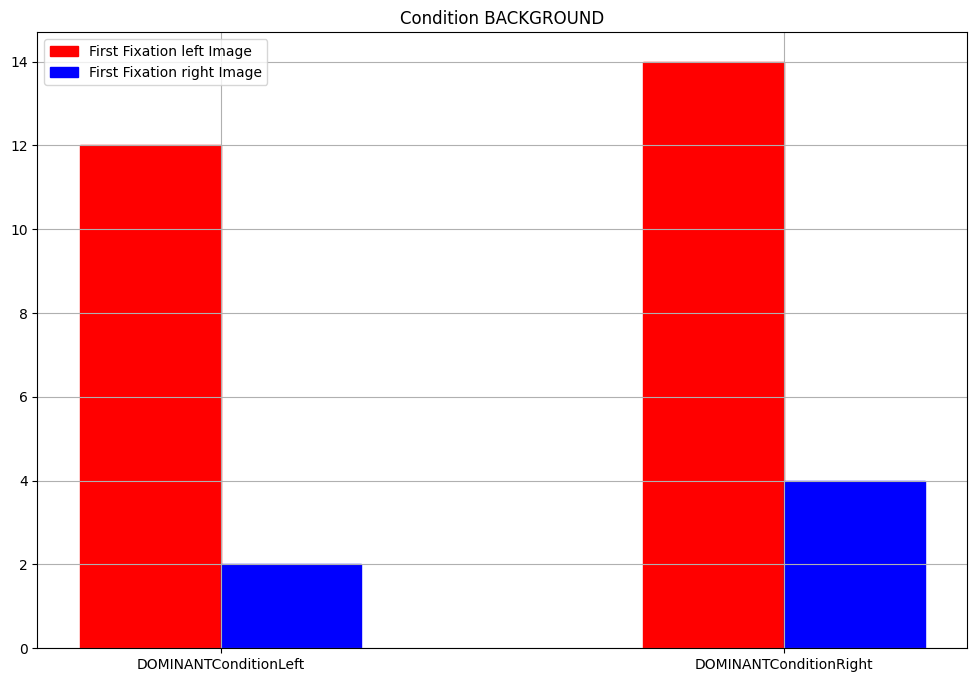

In [179]:
def addSubjectColumn(data_path, subject_number):
    df = pd.read_csv(data_path, sep='\t')
    df['subject'] = subject_number
    #df = df[df['FPOGV']==1]
    return df

def createSubjectFilePool():
    d = {'data_path': ['C:/Users/madle/Downloads/subject-1.tsv', 'C:/Users/madle/Downloads/subject-2.tsv'], 'subject_number': [1, 2]}
    df = pd.DataFrame(data=d)
    return df



df_files = createSubjectFilePool()

def plotCondition(trial_condition):
    all_fix_points = []
    for index, row in df_files.iterrows():
        df_subject = addSubjectColumn(row['data_path'],row['subject_number'])
        trials = df_subject[df_subject['USER'].str.contains(trial_condition, na=False)]
        fix_points = firstFixationPoints(subject_number,df_subject,trials)
        all_fix_points.extend(fix_points)
    plotDistribution(all_fix_points)

plotCondition('BASELINE')
plotCondition('SIZE')
plotCondition('FORM')
plotCondition('BACKGROUND')
